# Prediction of Obesity Risk - Modelling

## Problem Statement

# Import Libraries

In [24]:
import pandas as pd
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')
plt.rcParams['axes.spines.top'] = False    # Remove top border
plt.rcParams['axes.spines.right'] = False  # Remove right border

# Load Data

In [2]:
data = pd.read_csv('../Data/Processed/processed_with_outliers.csv')
print(f'Dataset has {data.shape[0]} rows and {data.shape[1]} columns')

Dataset has 20758 rows and 17 columns


In [3]:
# Creating a copy of the dataset in memory in case of misediting
df = data.copy()

# Data Preprocessing

In [4]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)
        
print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 9 ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numeric columns: 8 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


In [5]:
# Removing target from the list and creating a categorical feature lits
cat_features = cat_cols[:-1]
print(cat_features)
print(cat_cols)

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
lbl_encoder = LabelEncoder()
df['NObeyesdad'] = lbl_encoder.fit_transform(df['NObeyesdad'])
df['NObeyesdad'].value_counts()

NObeyesdad
4    4046
3    3248
1    3082
2    2910
0    2523
6    2522
5    2427
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Split the Dataset

In [10]:
x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

## Transform Data

In [11]:
# Define transformers for different column types
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine transformers for specific columns
preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_cols),
    ("cat", categorical_transformer, cat_features)
])

# Fit transformers on training data only
preprocessor.fit(x_train)

# Transform train and test data using fitted transformers
x_train_transformed = preprocessor.transform(x_train)
x_test_transformed = preprocessor.transform(x_test)


# Evaluating Different Algorithms

In this section we'll evaluate non-linear and ensemble algorithms using k-fold cross validation.

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [13]:
def model_evaluation(x, y, models):
    '''
        This function takes x, y and models and applies 
        k-fold cross validation to the each algorithm in 
        the models list by using x and y training set. 
        Displays the mean and standard deviation of 
        accuracy, precision, recall, f1 scores in tabular
        format and boxplots.

        ---
        ### Parameters
        - x <array>: Feature values.
        - y <array>: Target values.
        - models <list>: List of the model objects to be vealuated.
    '''
    
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = KFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
    
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])
        
    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    
    # Display the overall results in a boxplot graph
    width = (len(models)*2)
    plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(width, 6))
    fig, ax = plot_objects
    
    ax.boxplot(results_acc)
    ax.set_title('Accuracy', fontsize=14)
    ax.set_xticklabels(names, rotation=30)
    plt.tight_layout()
    plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))

/var/folders/xm/3h6hfxmn0158s2wvp_w5r6700000gn/T/ipykernel_96132/1721129131.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt

           Acc Mean  Acc STD
Algorithm                   
RFC           0.895    0.008
ABC           0.482    0.066
GBC           0.906    0.005


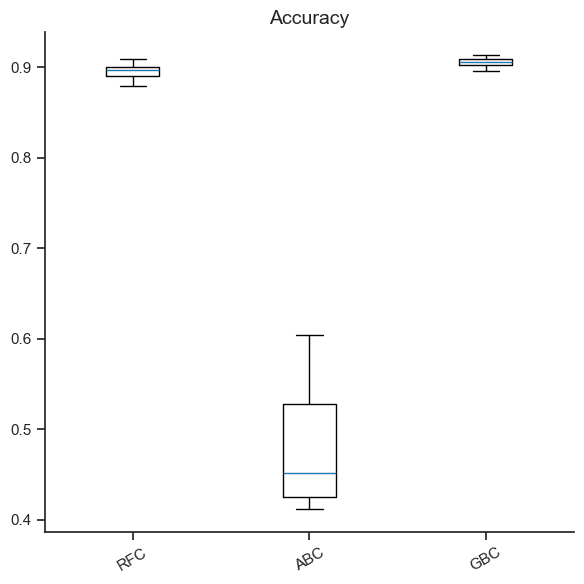

In [16]:
model_evaluation(x_train_transformed, y_train, ens_models)

In [17]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

/var/folders/xm/3h6hfxmn0158s2wvp_w5r6700000gn/T/ipykernel_96132/1721129131.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)


           Acc Mean  Acc STD
Algorithm                   
SVC           0.877    0.007
DTC           0.845    0.007
KNN           0.755    0.015
GNB           0.608    0.020


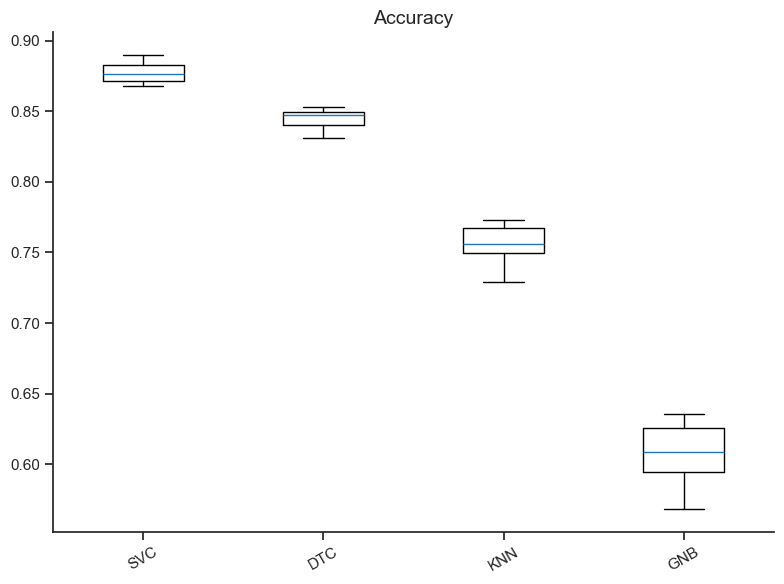

In [18]:
nl_models = []
nl_models.append(('SVC', SVC()))
nl_models.append(('DTC', DecisionTreeClassifier()))
nl_models.append(('KNN', KNeighborsClassifier()))
nl_models.append(('GNB', GaussianNB()))

model_evaluation(x_train_transformed, y_train, nl_models)

In [19]:
GBC = GradientBoostingClassifier()

GBC.fit(x_train_transformed, y_train)

y_hat = GBC.predict(x_test_transformed)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [21]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       505
           1       0.86      0.87      0.87       617
           2       0.88      0.89      0.89       582
           3       0.96      0.97      0.97       650
           4       1.00      1.00      1.00       809
           5       0.79      0.75      0.77       485
           6       0.78      0.80      0.79       504

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



In [101]:
def plot_confusion_matrix(y_test, predictions):
    # Plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions)
    fig = plt.subplots(figsize=(10, 8))
    sb.set(font_scale=1.4)
    sb.heatmap(cf_matrix, annot=True)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

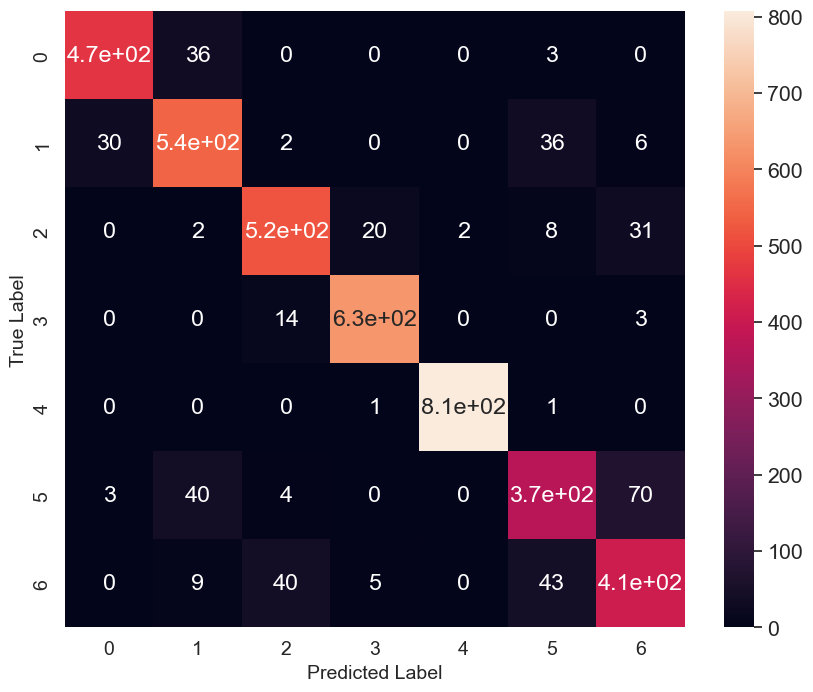

In [102]:
plot_confusion_matrix(y_test, y_hat)

In [28]:
from xgboost import XGBClassifier

           Acc Mean  Acc STD
Algorithm                   
XGB           0.907    0.006


/var/folders/xm/3h6hfxmn0158s2wvp_w5r6700000gn/T/ipykernel_96132/1721129131.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)


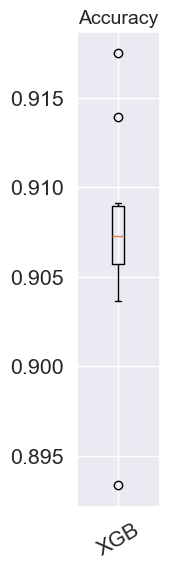

In [36]:
nl_models = []
nl_models.append(('XGB', XGBClassifier()))

model_evaluation(x_train_transformed, y_train, nl_models)

In [52]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [53]:
y_hat = xgb_model.predict(x_test_transformed)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       505
           1       0.86      0.88      0.87       617
           2       0.89      0.88      0.89       582
           3       0.96      0.97      0.97       650
           4       1.00      1.00      1.00       809
           5       0.79      0.76      0.77       485
           6       0.78      0.79      0.79       504

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



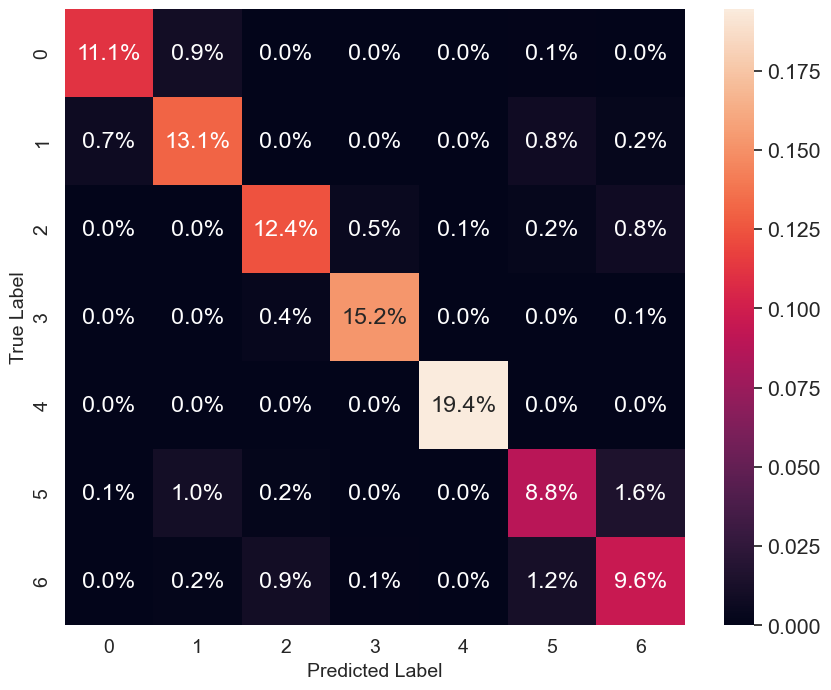

In [38]:
plot_confusion_matrix(y_test, y_hat)

## Hyperparameter Tuning

In [49]:
import sklearn.metrics

In [42]:
from sklearn.model_selection import GridSearchCV

In [55]:
XGB = XGBClassifier()

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=101)

h_params = {
    'eta': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10]
}
grid = GridSearchCV(
    estimator = XGB,
    param_grid = h_params,
    scoring = 'accuracy', 
    n_jobs = -1,
    cv = crossvalidation)

grid.fit(x_train_transformed, y_train)

# Print the best score and the hyper parameters that provides that score
grid.best_params_, grid.best_score_

({'eta': 0.2, 'max_depth': 5}, 0.9070818560884787)

In [56]:
model = XGBClassifier(**grid.best_params_)
model.fit(x_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [57]:
y_hat = model.predict(x_test_transformed)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       505
           1       0.86      0.88      0.87       617
           2       0.90      0.89      0.89       582
           3       0.96      0.97      0.97       650
           4       1.00      1.00      1.00       809
           5       0.80      0.76      0.78       485
           6       0.79      0.81      0.80       504

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



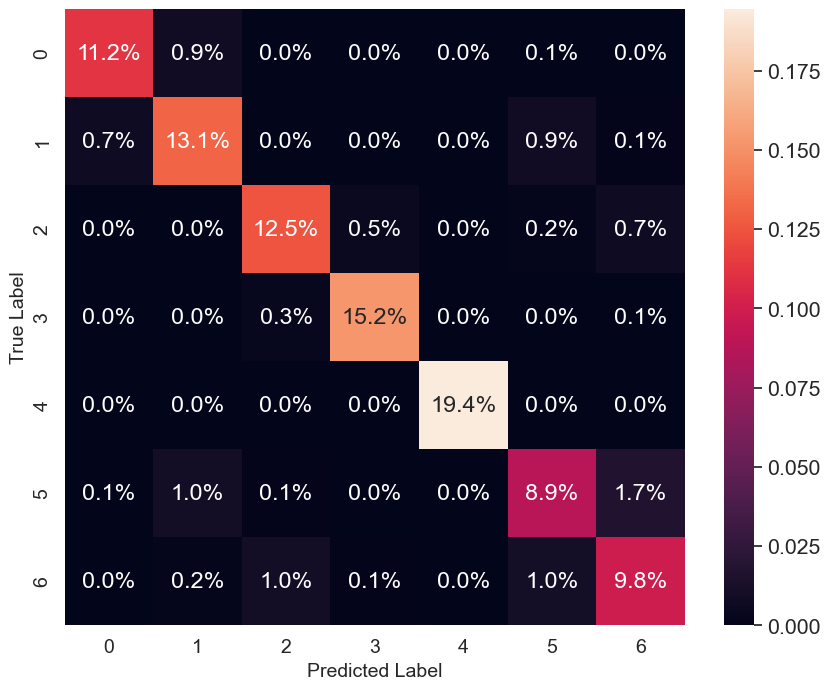

In [58]:
plot_confusion_matrix(y_test, y_hat)

In [107]:
def plot_roc_curve(y_true, predictions, estimator=None, class_names=None):
  """
  Plots ROC curves for all classes in a multi-class classification problem.

  Args:
    y_true: True labels for each data point.
    predictions: Predicted scores for each data point (should be probabilities).
    class_names: Names of the classes (optional).
    estimator: The name of the estimator.

  Returns:
    None. The ROC curve is plotted directly.
  """

  # Ensure binary representation of classes
  n_classes = len(np.unique(y_true))
  if n_classes < 2:
    raise ValueError("y_true must contain at least two classes.")
  
  predictions = predictions.flatten()

  # Initialize figure and subplot
  plt.figure(figsize=(10, 6))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot perfect classification line

  # Calculate ROC curves for each class
  fpr, tpr, roc_auc = {}, {}, {}
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])
    label = ''
    if class_names:
      label = '%s (AUC = %0.2f)' % (class_names[i], roc_auc[i])
    else:
      label = 'Class %d (AUC = %0.2f)' % (i, roc_auc[i])
    plt.plot(fpr[i], tpr[i], label=label)

  # Customize plot
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for Multi-class Classification: {estimator}')
  plt.legend(loc="lower right")

  plt.show()   

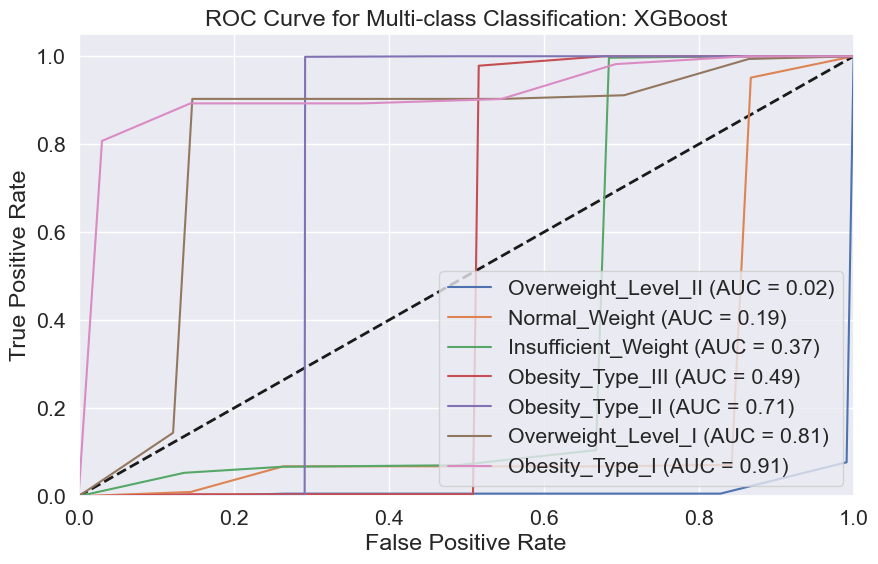

In [106]:
plot_roc_curve(y_test, y_hat, estimator='XGBoost', class_names=list(data['NObeyesdad'].unique()))

In [108]:
GBC = GradientBoostingClassifier()

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=101)

h_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 8],
    'min_samples_split': [5, 10, 20],
}
grid = GridSearchCV(
    estimator = GBC,
    param_grid = h_params,
    scoring = 'accuracy', 
    n_jobs = -1,
    cv = crossvalidation)

grid.fit(x_train_transformed, y_train)

# Print the best score and the hyper parameters that provides that score
grid.best_params_, grid.best_score_

# Next Steps

- Modelling